second metric.ipynb to run simultaneously

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union
import pandas as pd

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from src.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score
from src.denoise_utils import denoise
from src.sampling_utils import random_step, langevin_step, repulsive_step_parallel
from src.kernel import RBF
from src.embedding import CNN64, CNN16, init_weights, AverageDim, Average, VAEAverage, Style, VGG, VGG_dropout, VGG_noise
from src.datasets import StyleDataset, ArtistDataset
from src.train import train
from src.metric_utils import fid_metric, get_metric

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from collections import deque
from torch.utils.data import DataLoader, Dataset, random_split
from glob import glob
import pickle

In [2]:
# Load stats
with open('data/final/stats_fid.pkl','rb') as f: 
    stats = pickle.load(f)
with open('data/final/local_fid.pkl','rb') as f: 
    local = pickle.load(f)
with open('data/final/gram64_fid.pkl','rb') as f: 
    gram64 = pickle.load(f)

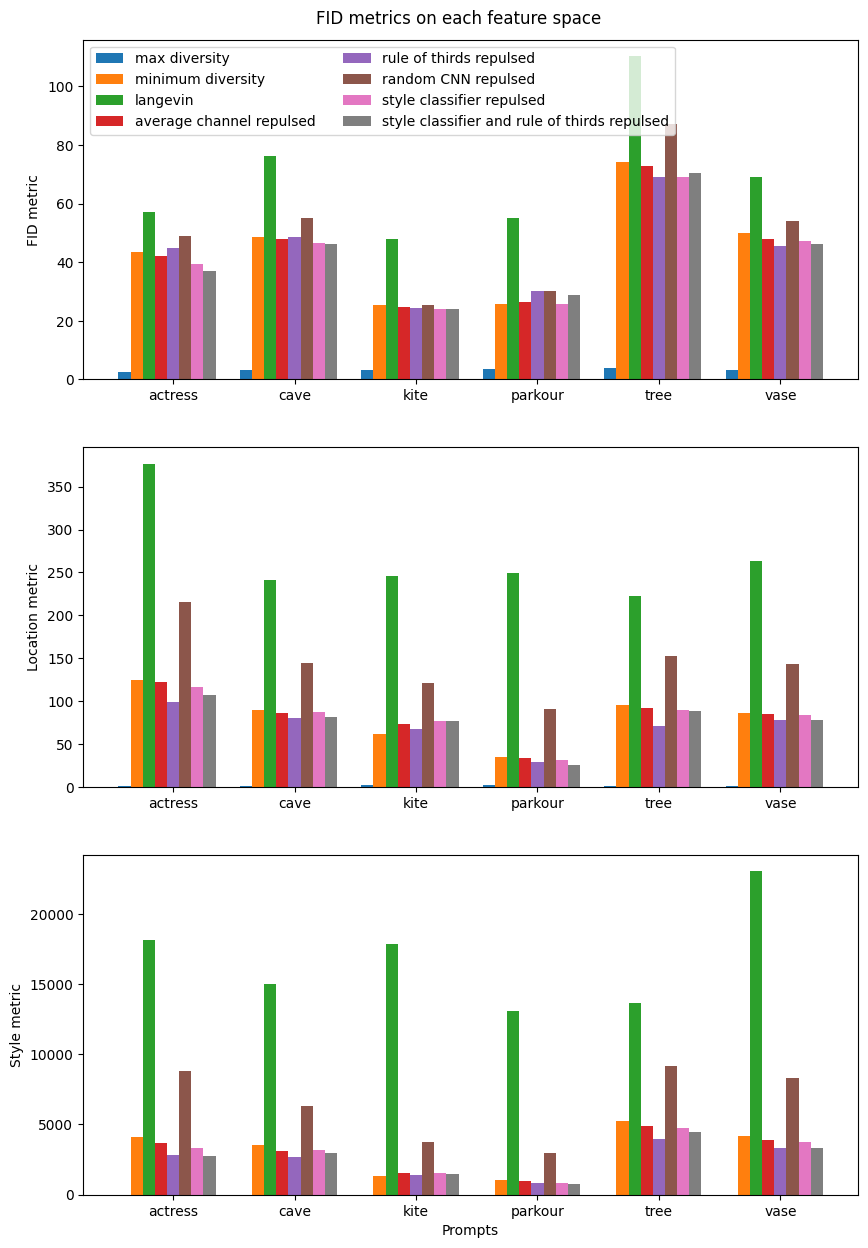

In [3]:
# Plot all FID metrics for all prompts
# methods are all separate colours, x axis is the prompt
exp_names = {
    'max_div2': 'max diversity',
    'min_div':'minimum diversity',
    'langevin': 'langevin',
    # 'eulera': 'stochastic scheduler',
    'averagedim_all_r1000': 'average channel repulsed',
    'ro3_all_r1000': 'rule of thirds repulsed',
    'cnn16_all_r1000':'random CNN repulsed',
    'vgg_noise_all_r1000':'style classifier repulsed',
    'vgg_noisero3_all_r1000':'style classifier and rule of thirds repulsed'
}
met_names = ['FID','Location','Style']
subjects = ['actress','cave','kite','parkour','tree','vase']
width=0.1
plt.figure(figsize=(10,15))

for i, data in enumerate([stats, local, gram64]):
    plt.subplot(3,1,i+1)
    for j, exp in enumerate(exp_names):
        values = []
        for subject in subjects:
            values.append(data[subject, exp])
        plt.bar(np.array(range(len(values))) + j*width, values, width, label=exp_names[exp])
    plt.xticks(np.array(range(len(values))) + len(exp_names)//2*width, subjects)#, rotation=45)
    plt.ylabel(f'{met_names[i]} metric')
    if i==0:
        plt.legend(loc='upper left', ncol=2)
    if i==2:
        plt.xlabel('Prompts')
plt.suptitle('FID metrics on each feature space', y=0.9)
# plt.savefig('data/final/fid_plot.pdf')
plt.show()

max_div2 FID - 3.31
min_div FID - 44.60
langevin FID - 69.33
averagedim_all_r1000 FID - 43.67
ro3_all_r1000 FID - 43.74
cnn16_all_r1000 FID - 50.15
vgg_noise_all_r1000 FID - 41.99
vgg_noisero3_all_r1000 FID - 42.11
max_div2 Location - 1.54
min_div Location - 82.16
langevin Location - 266.34
averagedim_all_r1000 Location - 81.95
ro3_all_r1000 Location - 70.82
cnn16_all_r1000 Location - 144.35
vgg_noise_all_r1000 Location - 81.14
vgg_noisero3_all_r1000 Location - 76.21
max_div2 Style - 0.85
min_div Style - 3234.98
langevin Style - 16779.18
averagedim_all_r1000 Style - 3013.89
ro3_all_r1000 Style - 2515.29
cnn16_all_r1000 Style - 6540.45
vgg_noise_all_r1000 Style - 2897.33
vgg_noisero3_all_r1000 Style - 2617.92


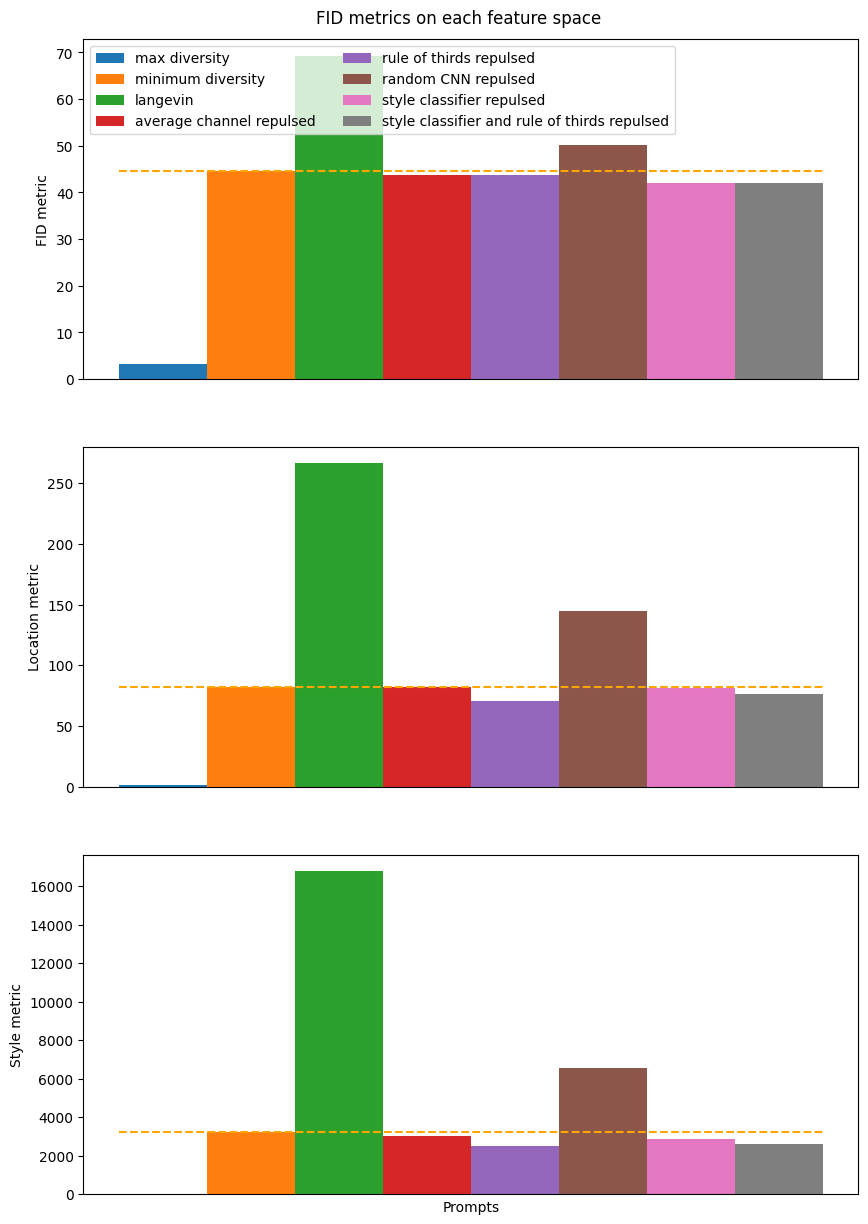

In [9]:
# Plot all FID metrics - AVERAGE OVER PROMPTS
# methods are all separate colours, x axis is the prompt
exp_names = {
    'max_div2': 'max diversity',
    'min_div':'minimum diversity',
    'langevin': 'langevin',
    # 'eulera': 'stochastic scheduler',
    'averagedim_all_r1000': 'average channel repulsed',
    'ro3_all_r1000': 'rule of thirds repulsed',
    'cnn16_all_r1000':'random CNN repulsed',
    'vgg_noise_all_r1000':'style classifier repulsed',
    'vgg_noisero3_all_r1000':'style classifier and rule of thirds repulsed'
}
met_names = ['FID','Location','Style']
subjects = ['actress','cave','kite','parkour','tree','vase']
width=1



plt.figure(figsize=(10,15))

for i, data in enumerate([stats, local, gram64]):
    ax = plt.subplot(3,1,i+1)
    min_div_val = 0
    for j, exp in enumerate(exp_names):
        value = 0
        for s, subject in enumerate(subjects):
            value += data[subject, exp]
        value /= len(subjects)
        print(f"{exp} {met_names[i]} - {value:.2f}")
        if exp=="min_div":
            min_div_val = value
        plt.bar(j*width, value, width, label=exp_names[exp])
    plt.xticks([])
    # plt.xticks(len(exp_names)//2*width, subjects)#, rotation=45)
    plt.ylabel(f'{met_names[i]} metric')
    if i==0:
        plt.legend(loc='upper left', ncol=2)
    if i==2:
        plt.xlabel('Prompts')
    # ax.plot(0,2000,1,2000, secondary_y=True)
    # if exp=='min_div':
    # line = pd.DataFrame({'line' : [value]*len(exp_names)})
    # line['line'].plot(secondary_y=True)
    # plt.plot([value]*len(exp_names)
    plt.plot(np.array(range(len(exp_names)+1)) - 0.5, [min_div_val]*(len(exp_names)+1), '--', color='orange')
plt.suptitle('FID metrics on each feature space', y=0.9)
# plt.savefig('data/final/fid_plot_average.pdf')

plt.show()

In [5]:
# TODO: put in table,for each prompt + average?
6*3*8

144

In [6]:
# average over prompts
for subject in subjects:
    

{('actress', 'max_div2'): 2.6552651072954063,
 ('actress', 'min_div'): 43.45555816650099,
 ('actress', 'eulera'): 44.318960219877624,
 ('actress', 'langevin'): 57.27426524591996,
 ('actress', 'averagedim_all_r1000'): 42.21837858010596,
 ('actress', 'ro3_all_r1000'): 44.90900170871956,
 ('actress', 'cnn16_all_r1000'): 48.997696597240775,
 ('actress', 'vgg_noise_all_r1000'): 39.3273215580102,
 ('actress', 'vgg_noisero3_all_r1000'): 37.11723985642797,
 ('cave', 'max_div2'): 3.1619584465502157,
 ('cave', 'min_div'): 48.56374534667816,
 ('cave', 'eulera'): 49.27348402369665,
 ('cave', 'langevin'): 76.12688577222633,
 ('cave', 'averagedim_all_r1000'): 47.80810688093999,
 ('cave', 'ro3_all_r1000'): 48.45735965598024,
 ('cave', 'cnn16_all_r1000'): 55.198285150919844,
 ('cave', 'vgg_noise_all_r1000'): 46.61704711309761,
 ('cave', 'vgg_noisero3_all_r1000'): 46.06269671225249,
 ('kite', 'max_div2'): 3.335417847503379,
 ('kite', 'min_div'): 25.47334429619474,
 ('kite', 'eulera'): 30.47820711956637